In [64]:
import numpy as np

class NeuralNetwork():
    def __init__(self, inputLayerSize, hiddenLayerSize, outputLayerSize):
        self.inputLayerSize = inputLayerSize 
        self.hiddenLayerSize = hiddenLayerSize 
        self.outputLayerSize = outputLayerSize 

        # Initialize Weights
        self.Wh = np.random.randn(inputLayerSize, hiddenLayerSize) * \
                    np.sqrt(2.0/self.inputLayerSize)
        self.Wo = np.random.randn(hiddenLayerSize, outputLayerSize) * \
                    np.sqrt(2.0/self.hiddenLayerSize)

        # Initialize Biases
        self.Bh = np.full((1, hiddenLayerSize), 0.1)
        self.Bo = np.full((1, outputLayerSize), 0.1)
    
    def relu(self, Z):
        return np.maximum(0, Z)
    
    def relu_prime(self, Z):
        '''
        Z - weighted input matrix

        Returns the gradient of the 
        Z matrix where all negative 
        values are switched to 0 and
        all positive values switched to 1
        '''
        Z[Z < 0] = 0
        Z[Z > 0] = 1
        return Z
    
    def cost(self, output, y):
        cost = np.sum((output - y)**2) / 2.0
        return cost
    
    def cost_prime(self, output, y):
        return output - y

    def feed_forward(self, X):
        # Hidden layer
        Zh = np.dot(X, self.Wh) + self.Bh
        H = self.relu(Zh)

        # Output layer
        Zo = np.dot(H, self.Wo) + self.Bo
        output = self.relu(Zo)
        return output
    
    def backprop(self, X, y, lr):
        '''
        X - input matrix from training set
        y - expected output matrix
        lr - learning rate
        '''
        ### Feed Forward ###
   
        # Hidden layer
        Zh = np.dot(X, self.Wh) + self.Bh
        H = self.relu(Zh)

        # Output layer
        Zo = np.dot(H, self.Wo) + self.Bo
        out = self.relu(Zo)

        #### Backprop ####

        # Layer Error
        Eo = (out - y) * self.relu_prime(Zo)
        Eh = np.dot(Eo, self.Wo.T) * self.relu_prime(Zh)

        # Cost derivative for weights
        dWo = np.dot(H.T, Eo)
        dWh = np.dot(X.T, Eh)

        # Cost derivative for bias
        dBo = np.sum(Eo, axis=0, keepdims=True)
        dBh = np.sum(Eh, axis=0, keepdims=True)

        # Update weights
        self.Wo -= lr * dWo
        self.Wh -= lr * dWh

        # Update biases
        self.Bo -= lr * dBo
        self.Bh -= lr * dBh
        
    def SGD(self, data, batch_size, lr):
        N = len(data)
        np.random.shuffle(data)
        mini_batches = np.array(
            [data[i:i+batch_size] for i in range(0, N, batch_size)])
        for batch in mini_batches:
            X,y = self.get_normalized_xy_from_batch(batch)
            self.backprop(X, y, lr)

    def train(self, data, epochs, batch_size, lr):
        cost_history = []
        for epoch in range(epochs):
            self.SGD(data, batch_size, lr)
            
            # Store cost for auditing purposes
            X,y = self.get_normalized_xy_from_batch(data)
            cost = self.cost(self.feed_forward(X), y)
            cost_history.append(cost)
            
            # Log cost
            if epoch % 5000 == 0:
                print("Epoch "+str(epoch)+" Cost:"+str(round(cost,5)))
        return cost_history
    
    def predict(self, X, y_min, y_max):
        X = self.normalize(X, new_min=0, new_max=1)
        X.shape = (len(X),1)
        output = self.feed_forward(X)
        denormalized_output = self.denormalize(output, y_min, y_max)
        return denormalized_output

    def normalize(self, arr, new_min, new_max):
        cur_min = np.min(arr)
        cur_max = np.max(arr)
        cur_range = (cur_max - cur_min)  
        new_range = (new_max - new_min)
        return (((arr - cur_min) * new_range) / cur_range) + new_min

    def denormalize(self, normalized, old_min, old_max):
        return self.normalize(normalized, old_min, old_max)
    
    def get_normalized_xy_from_batch(self, batch):
        X = batch[:,0]
        y = batch[:,1]
        X = self.normalize(X, new_min=0, new_max=1)
        y = self.normalize(y, new_min=0, new_max=1)
        X.shape = (len(X),1)
        y.shape = (len(y),1)
        return X,y

### Visualize

In [65]:
import matplotlib.pyplot as plt

def graph(x, y, xlabel="X", ylabel="Y", title="X vs Y"):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def graph_error(error_history):
    iterations = [i for i in range(1,len(error_history)+1)]
    plt.plot(iterations, error_history)
    plt.title('Error Rate')
    plt.xlabel('Training Iterations')
    plt.ylabel('Mean Squared Error')
    plt.show()

### Load Data

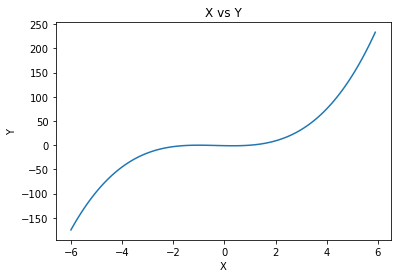

[[  -6.    -175.   ]
 [  -5.9   -165.669]
 [  -5.8   -156.672]]


In [66]:
def cubic(x):
    return x**3 + x**2 - x - 1

def get_cubic_data(start,end,step_size=1):
    data = np.array([ [i,cubic(i)] for i in 
         np.arange(start,end,step_size)], dtype="float64")    
    return data

data = get_cubic_data(-6,6,.1)
X = data[:,0]
y = data[:,1]
graph(X,y)
print (data[:3])

### Train

In [88]:
data = get_cubic_data(-20,20)
nn = NeuralNetwork(1,20,1)
print(nn.Wh)

[[ 0.74677633 -0.53280028  0.85282615  0.45773279  1.21653317  1.54702185
   2.15570195  3.28346775  2.05488922  1.87836682  1.64426893  1.13606563
  -1.45146137  0.3536892  -0.69892677 -0.10106068  2.41998082  1.64716872
  -1.0361952  -0.42603976]]


In [ ]:
cost_hist = nn.train(data, epochs=100000, batch_size=40, lr=.0005)
print("Final cost " + str(round(cost_hist[-1],5)))
graph_error(cost_hist[75:])

Epoch 0 Cost:5.99484
Epoch 5000 Cost:5.99484


### Predict

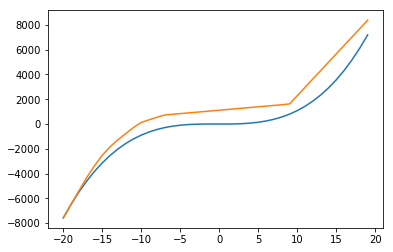

In [71]:
start,end = (-20,20)
data = get_cubic_data(start, end)
X,y = data[:,0],data[:,1]
predictions = nn.predict(X, y_min=cubic(start), y_max=cubic(end))
plt.plot(X, y)
plt.plot(X, predictions)

plt.show()